- AnnualCrop
- Forest
- HerbaceousVegetation
- Highway
- Industrial
- Pasture
- PermanentCrop
- Residential
- River
- SeaLake


# Basic information

Category: AnnualCrop, Image Size: (64, 64), Total Images: 3000
Category: Forest, Image Size: (64, 64), Total Images: 3000
Category: HerbaceousVegetation, Image Size: (64, 64), Total Images: 3000
Category: Highway, Image Size: (64, 64), Total Images: 2500
Category: Industrial, Image Size: (64, 64), Total Images: 2500
Category: Pasture, Image Size: (64, 64), Total Images: 2000
Category: PermanentCrop, Image Size: (64, 64), Total Images: 2500
Category: Residential, Image Size: (64, 64), Total Images: 3000
Category: River, Image Size: (64, 64), Total Images: 2500
Category: SeaLake, Image Size: (64, 64), Total Images: 3000


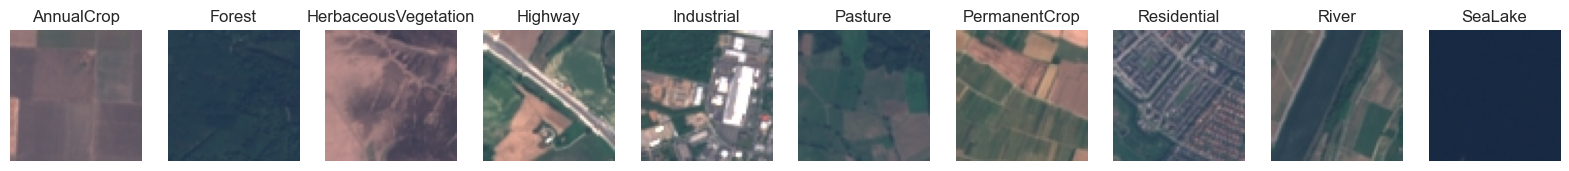

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set the path to the dataset
dataset_path = 'data'

# Get folders for all categories
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Initialize data storage
image_count = {}
example_images = {}

# Iterate over each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    image_count[category] = len(images)

    # Load the first image as an example
    first_image_path = os.path.join(category_path, images[0])
    with Image.open(first_image_path) as img:
        example_images[category] = img.copy()
        print(f"Category: {category}, Image Size: {img.size}, Total Images: {len(images)}")

# Display an example image for each category
fig, axes = plt.subplots(1, len(categories), figsize=(20, 5))
for ax, (category, img) in zip(axes, example_images.items()):
    ax.imshow(img)
    ax.set_title(category)
    ax.axis('off')
plt.show()


# ANN model

Found 1728 validated image filenames belonging to 10 classes.
Found 432 validated image filenames belonging to 10 classes.
Found 540 validated image filenames belonging to 10 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_68 (Dense)            (None, 512)               6291968   
                                                                 
 dropout_62 (Dropout)        (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 256)               131328    
                                                                 
 dropout_63 (Dropout)        (None, 256)               0         
                                                                 
 d

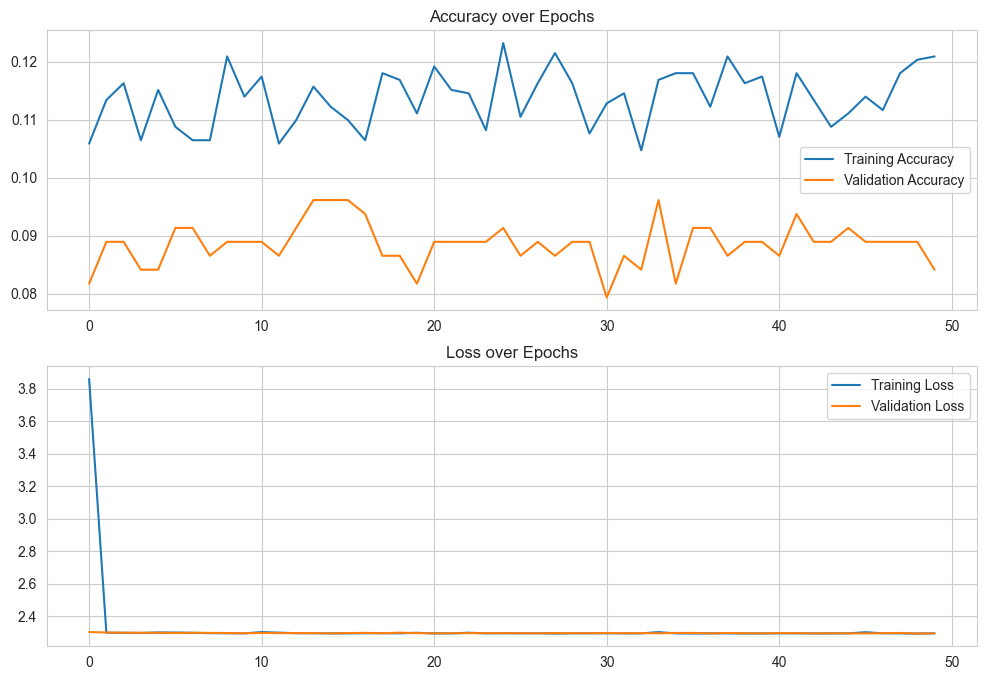

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load all image paths and divide
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = [os.path.join(category_path, img) for img in os.listdir(category_path)]
    image_paths.extend(images)
    labels.extend([category] * len(images))

sub_image_paths, _, sub_labels, _ = train_test_split(image_paths, labels, test_size=0.9, stratify=labels, random_state=42)

# Separate out the test set using train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(sub_image_paths, sub_labels, test_size=0.2, stratify=sub_labels, random_state=42)

# Convert data paths and labels to DataFrame
import pandas as pd

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})

# Define training and testing data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # For later confusion matrix plotting
)

# Build the ANN model
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Convert 64x64x3 images to one-dimensional arrays
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Output model summary
model.summary()

# Use callbacks to record the training process
from tensorflow.keras.callbacks import History
history = History()

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[history]
)

# Plot accuracy and loss during training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

model.save('ANN_model.h5')

# CNN model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load all image paths and split
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = [os.path.join(category_path, img) for img in os.listdir(category_path)]
    image_paths.extend(images)
    labels.extend([category] * len(images))

sub_image_paths, _, sub_labels, _ = train_test_split(image_paths, labels, test_size=0.9, stratify=labels, random_state=42)

# Separate out the test set using train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(sub_image_paths, sub_labels, test_size=0.2, stratify=sub_labels, random_state=42)

# Convert data paths and labels to DataFrame
import pandas as pd

train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})

# Define training and testing data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    shuffle=False  # For later confusion matrix plotting
)

# Build the CNN model
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Output model summary
model.summary()


Found 1728 validated image filenames belonging to 10 classes.
Found 432 validated image filenames belonging to 10 classes.
Found 540 validated image filenames belonging to 10 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 c

In [ ]:
# Record the training process
from tensorflow.keras.callbacks import History
history = History()

model.fit(
    train_generator,
    steps_per_epoch=train_generator.
    samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[history]
)


Epoch 1/50
54/54 [==============================] - 3s 38ms/step - loss: 1.9382 - accuracy: 0.2326 - val_loss: 1.5929 - val_accuracy: 0.3462
Epoch 2/50
54/54 [==============================] - 2s 35ms/step - loss: 1.5933 - accuracy: 0.3461 - val_loss: 1.5639 - val_accuracy: 0.3582
Epoch 3/50
54/54 [==============================] - 2s 35ms/step - loss: 1.5661 - accuracy: 0.3634 - val_loss: 1.4005 - val_accuracy: 0.4591
Epoch 4/50
54/54 [==============================] - 2s 35ms/step - loss: 1.3961 - accuracy: 0.4392 - val_loss: 1.3629 - val_accuracy: 0.4615
Epoch 5/50
54/54 [==============================] - 2s 35ms/step - loss: 1.3288 - accuracy: 0.4769 - val_loss: 1.2316 - val_accuracy: 0.5168
Epoch 6/50
54/54 [==============================] - 2s 34ms/step - loss: 1.2577 - accuracy: 0.5145 - val_loss: 1.2753 - val_accuracy: 0.5264
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 1.2333 - accuracy: 0.5451 - val_loss: 1.2730 - val_accuracy: 0.5168
Epoch 8/50
54

In [ ]:
model.save("CNN_model.h5")

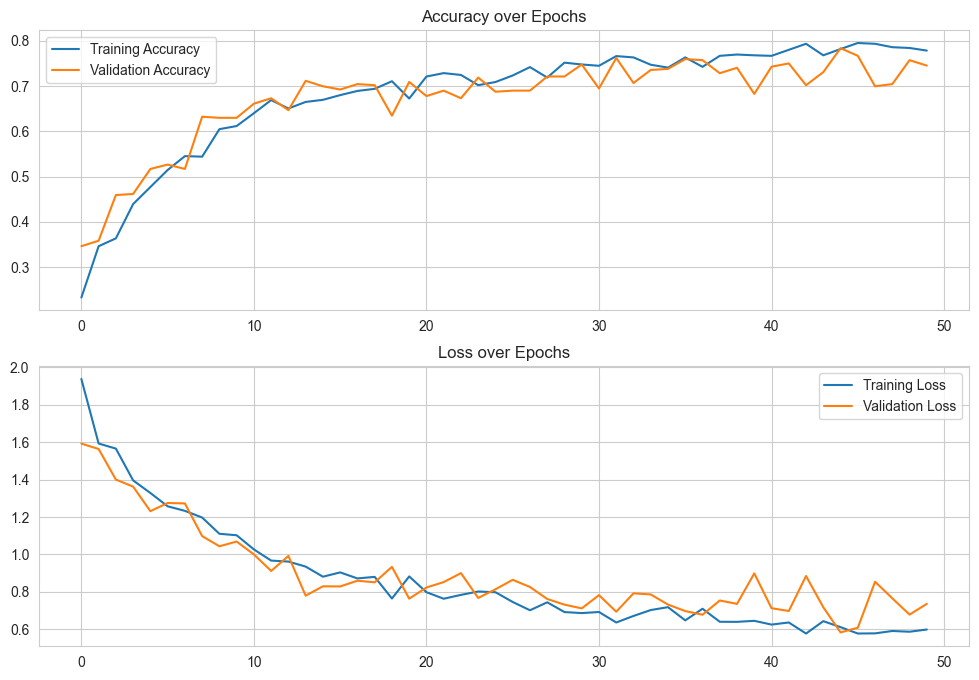

In [ ]:
# Plot accuracy and loss during training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

17/17 [==============================] - 0s 10ms/step


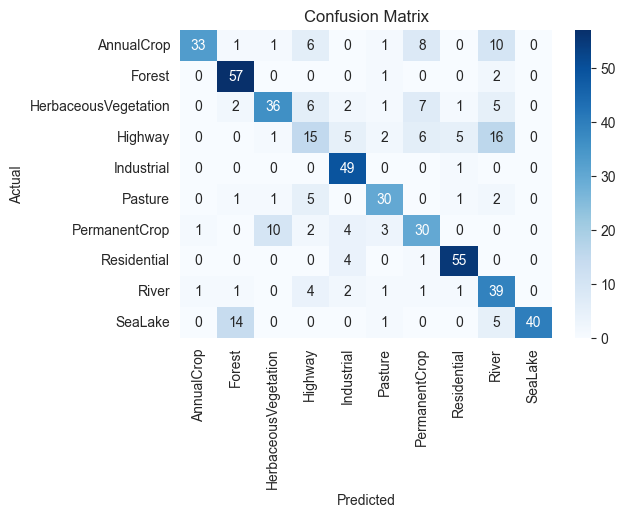

                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.55      0.69        60
              Forest       0.75      0.95      0.84        60
HerbaceousVegetation       0.73      0.60      0.66        60
             Highway       0.39      0.30      0.34        50
          Industrial       0.74      0.98      0.84        50
             Pasture       0.75      0.75      0.75        40
       PermanentCrop       0.57      0.60      0.58        50
         Residential       0.86      0.92      0.89        60
               River       0.49      0.78      0.60        50
             SeaLake       1.00      0.67      0.80        60

            accuracy                           0.71       540
           macro avg       0.72      0.71      0.70       540
        weighted avg       0.74      0.71      0.71       540



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Plot the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Output accuracy for each class
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))


1/1 [==============================] - 0s 72ms/step


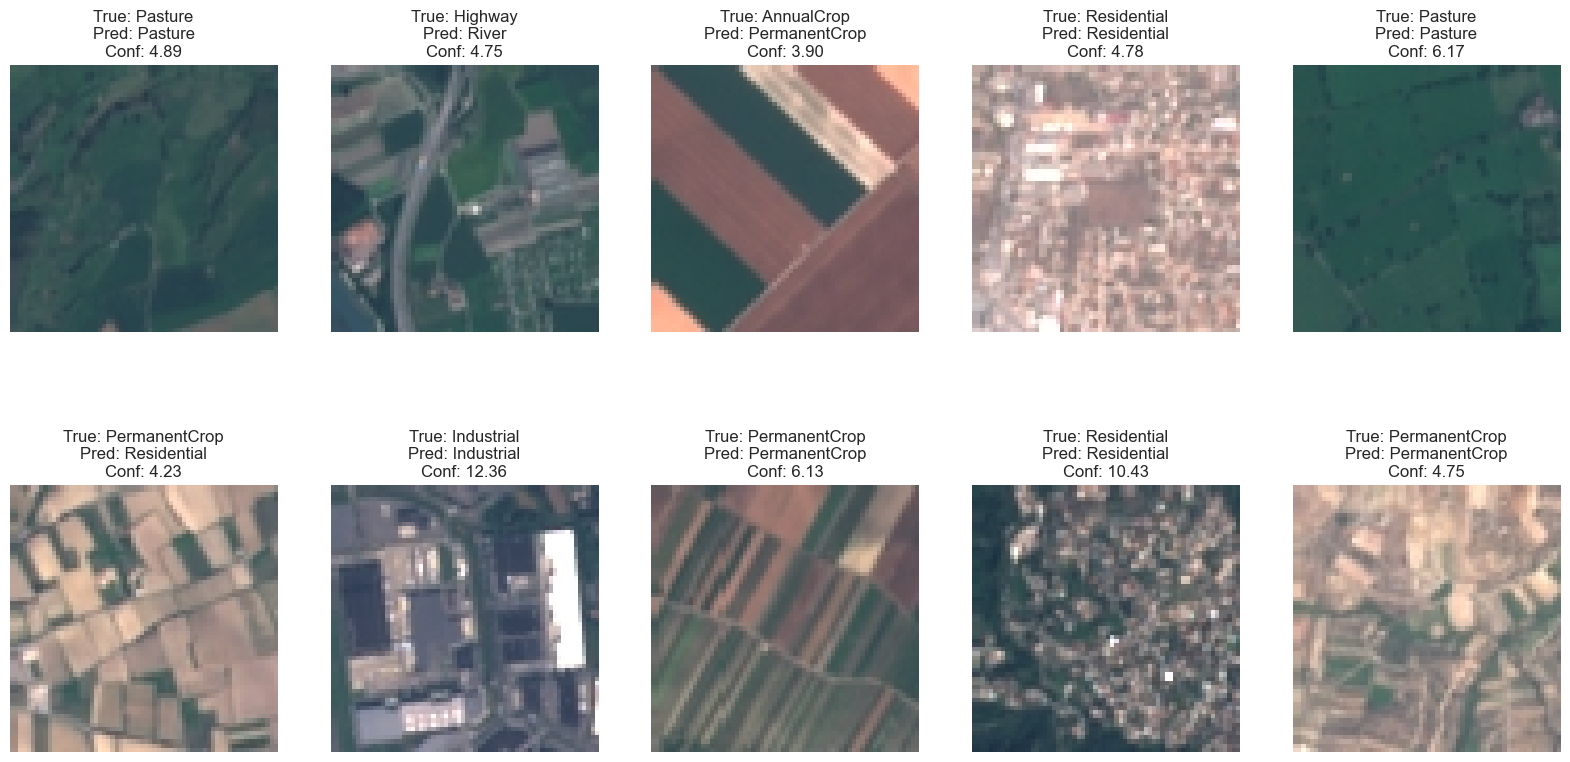

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_sample_predictions(model, test_generator, class_indices):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    index_to_class = {v: k for k, v in class_indices.items()}


    num_samples = 10
    indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(test_images[idx])
        plt.title(f'True: {index_to_class[test_labels[idx].item()]}\n'
                  f'Pred: {index_to_class[predicted_labels[idx].item()]}\n'
                  f'Conf: {np.max(predictions[idx]):.2f}')
        plt.axis('off')
    plt.show()


class_indices = test_generator.class_indices


show_sample_predictions(model, test_generator, class_indices)


# ViT model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)


Found 1728 validated image filenames belonging to 10 classes.
Found 432 validated image filenames belonging to 10 classes.
Found 540 validated image filenames belonging to 10 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = more_data(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


num_classes = len(train_df['class'].unique())
input_shape = (64, 64, 3)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
image_size = 64
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

# 数据增强
more_data = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="more_data",
)


x_train_sample = next(train_generator)[0]
more_data.layers[0].adapt(x_train_sample)


vit = create_vit_classifier()
history = run_experiment(vit)

vit.save('ViT_model.h5')


Epoch 1/50
54/54 [==============================] - 12s 156ms/step - loss: 4.1260 - accuracy: 0.2309 - top-5-accuracy: 0.7251 - val_loss: 1.7826 - val_accuracy: 0.3472 - val_top-5-accuracy: 0.8773
Epoch 2/50
54/54 [==============================] - 8s 140ms/step - loss: 1.9706 - accuracy: 0.3628 - top-5-accuracy: 0.8536 - val_loss: 1.4179 - val_accuracy: 0.4931 - val_top-5-accuracy: 0.9190
Epoch 3/50
54/54 [==============================] - 8s 141ms/step - loss: 1.6788 - accuracy: 0.4363 - top-5-accuracy: 0.8958 - val_loss: 1.2366 - val_accuracy: 0.5301 - val_top-5-accuracy: 0.9352
Epoch 4/50
54/54 [==============================] - 8s 141ms/step - loss: 1.4841 - accuracy: 0.5116 - top-5-accuracy: 0.9207 - val_loss: 1.1529 - val_accuracy: 0.6343 - val_top-5-accuracy: 0.9606
Epoch 5/50
54/54 [==============================] - 7s 136ms/step - loss: 1.3403 - accuracy: 0.5463 - top-5-accuracy: 0.9392 - val_loss: 1.1156 - val_accuracy: 0.6134 - val_top-5-accuracy: 0.9699
Epoch 6/50
54/54 [=

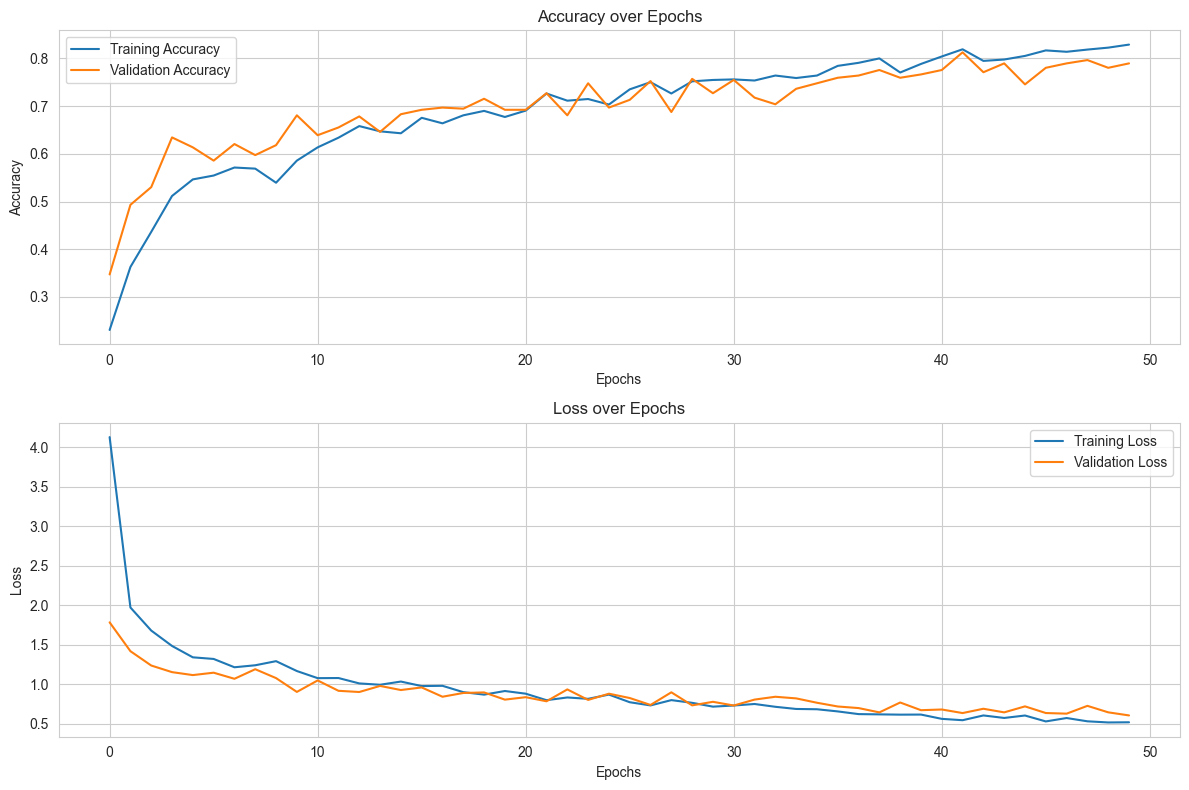

In [ ]:
# Import the required library for plotting
import matplotlib.pyplot as plt

# Plot accuracy and loss during training
def plot_training_history(history):
    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' is the history object returned by the model.fit() method
plot_training_history(history)


17/17 [==============================] - 0s 23ms/step


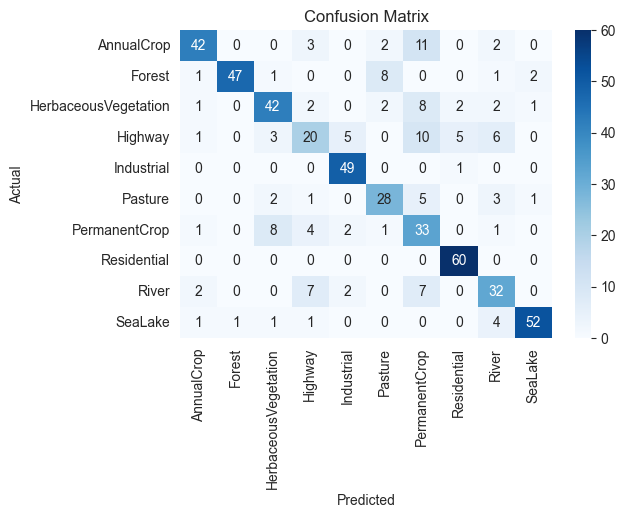

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.70      0.77        60
              Forest       0.98      0.78      0.87        60
HerbaceousVegetation       0.74      0.70      0.72        60
             Highway       0.53      0.40      0.45        50
          Industrial       0.84      0.98      0.91        50
             Pasture       0.68      0.70      0.69        40
       PermanentCrop       0.45      0.66      0.53        50
         Residential       0.88      1.00      0.94        60
               River       0.63      0.64      0.63        50
             SeaLake       0.93      0.87      0.90        60

            accuracy                           0.75       540
           macro avg       0.75      0.74      0.74       540
        weighted avg       0.76      0.75      0.75       540



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Plot the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Output accuracy for each class
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))


1/1 [==============================] - 0s 55ms/step


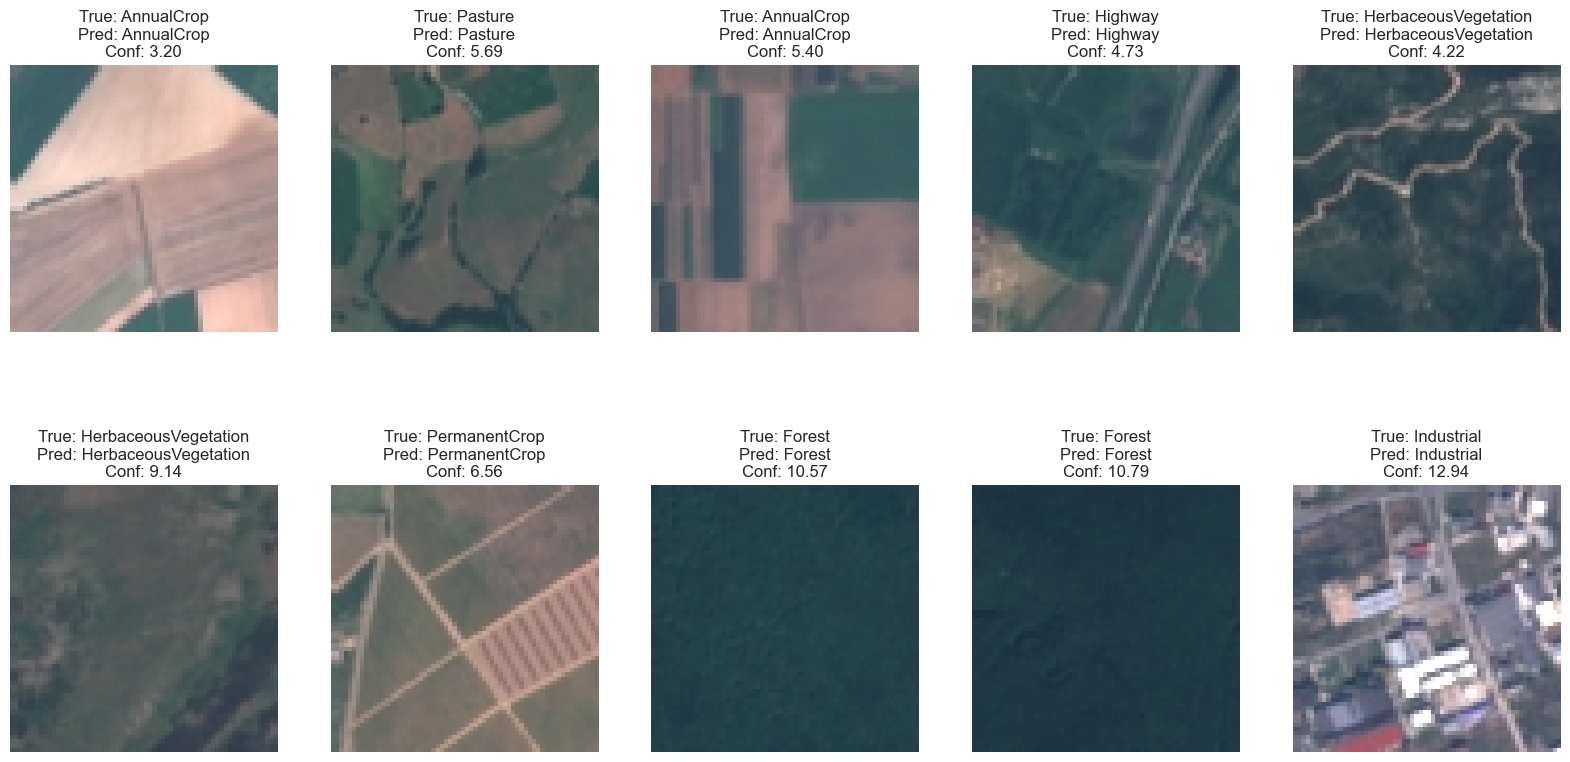

In [ ]:
def show_sample_predictions(model, test_generator, class_indices):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)


    index_to_class = {v: k for k, v in class_indices.items()}

    num_samples = 10  # 选择展示的样本数量
    indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(test_images[idx])
        plt.title(f'True: {index_to_class[test_labels[idx]]}\n'
                  f'Pred: {index_to_class[predicted_labels[idx]]}\n'
                  f'Conf: {np.max(predictions[idx]):.2f}')
        plt.axis('off')
    plt.show()


class_indices = test_generator.class_indices


show_sample_predictions(vit, test_generator, class_indices)
